In [3]:
import tensorquant as tq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

In [2]:
tq.Settings.evaluation_date = date(2024, 7, 31)

trade_date = tq.Settings.evaluation_date
market_data = {}

# Curves

In [6]:
ref_date = date(2024, 7, 31)
daycounter = tq.DayCounter(tq.DayCounterConvention.ActualActual)

mkt = pd.read_excel("data/market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]
#tq
curve_tq = tq.RateCurve(reference_date=ref_date,
                         pillars=estr_df['end'],
                         rates=rates,
                         interp='LINEAR',
                         daycounter_convention=tq.DayCounterConvention.ActualActual)

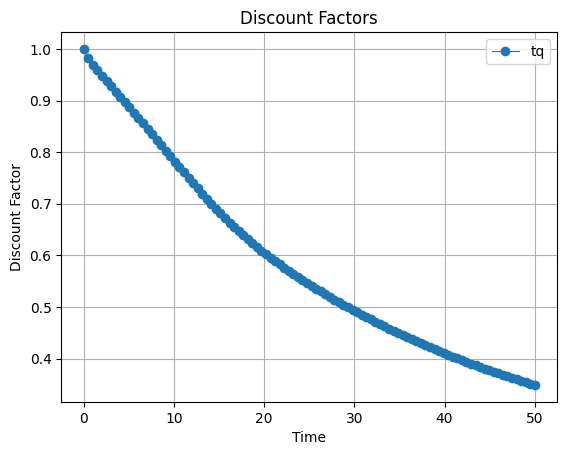

In [7]:
taus = np.linspace(0.0001,50, 100).tolist()
discount_tq = [curve_tq.discount(t) for t in taus]

plt.plot(taus, discount_tq, label='tq', marker='o',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Discount Factor')
plt.title('Discount Factors')
plt.legend()
plt.grid()
plt.show()

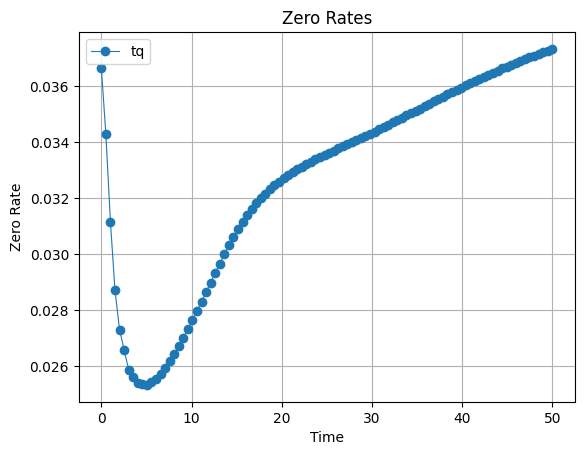

In [9]:
zerorate_tq = [curve_tq.zero_rate(t) for t in taus]

plt.plot(taus, zerorate_tq, label='tq', marker='o',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Zero Rate')
plt.title('Zero Rates')
plt.legend()
plt.grid()
plt.show()

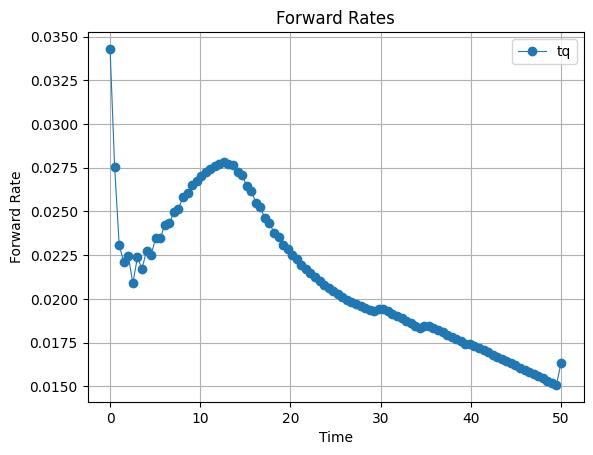

In [10]:
fwdrate_tq = [curve_tq.forward_rate(t, t+0.5) for t in taus]

plt.plot(taus, fwdrate_tq, label='tq', marker='o',  linewidth=0.8)

plt.xlabel('Time')
plt.ylabel('Forward Rate')
plt.title('Forward Rates')
plt.legend()
plt.grid()
plt.show()

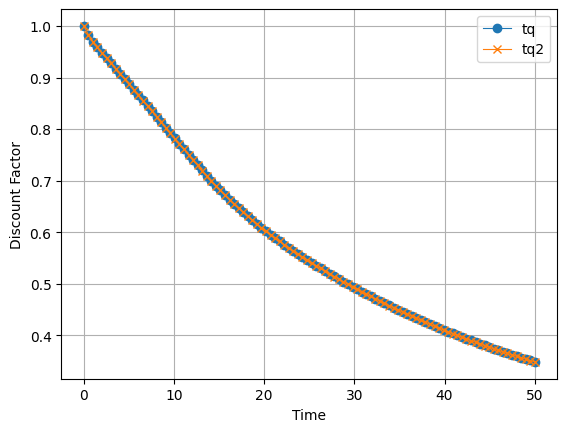

In [11]:
disc_fact = [df.numpy() for df in discount_tq]
curve_from_zcb = tq.RateCurve.from_zcb(ref_date, taus, disc_fact, interp='LINEAR', daycounter_convention=tq.DayCounterConvention.ActualActual) #[int(n) for n in (np.array(taus)*365).round(0)]

discount_tq = [curve_tq.discount(t) for t in taus]
discount_tq2 = [curve_from_zcb.discount(t) for t in taus]

plt.plot(taus, discount_tq, label='tq', marker='o',  linewidth=0.8)
plt.plot(taus, discount_tq2, label='tq2', marker='x',  linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid()
plt.show()

# ESTR Bootstrapping

In [12]:
curve_stripper_eur = tq.CurveBootstrap(evaluation_date=trade_date,
                                   daycount_convention=tq.DayCounterConvention.Actual365,
                                   curve_map=tq.curve_map)

In [13]:
eur_disc_name = "EUR:ESTR"
generators = estr_df['type'].tolist()
maturities = estr_df['term'].tolist()
quotes = estr_df['quote'].values/100

estr_curve = curve_stripper_eur.strip(generators, maturities, quotes, eur_disc_name,
                                               currency=tq.Currency.EUR, market_data=market_data)

total iteration:  4


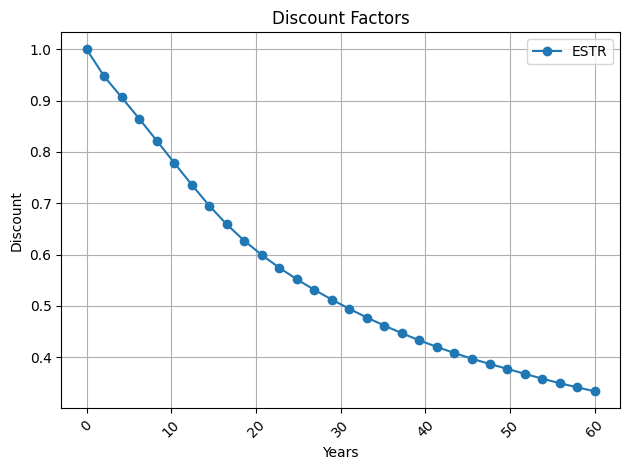

In [14]:
taus = np.linspace(0.01,60, 30)
discounts = [estr_curve.discount(t).numpy() for t in taus]

plt.plot(taus, discounts, label= 'ESTR', marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Discount')
plt.title('Discount Factors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
estr_curve.nodes

[(datetime.date(2024, 8, 1), 0.037157136408408745),
 (datetime.date(2024, 8, 2), 0.037157136408398704),
 (datetime.date(2024, 8, 5), 0.03714964222354124),
 (datetime.date(2024, 8, 9), 0.03673461501249365),
 (datetime.date(2024, 8, 16), 0.03667307440995199),
 (datetime.date(2024, 8, 23), 0.03664044841398159),
 (datetime.date(2024, 9, 2), 0.03660838953926473),
 (datetime.date(2024, 10, 2), 0.036073882700684574),
 (datetime.date(2024, 11, 4), 0.0353127471257709),
 (datetime.date(2024, 12, 2), 0.0348394662439544),
 (datetime.date(2025, 1, 2), 0.034273634115289),
 (datetime.date(2025, 2, 3), 0.033681706609810826),
 (datetime.date(2025, 3, 3), 0.033128312025028236),
 (datetime.date(2025, 4, 2), 0.03250640595195979),
 (datetime.date(2025, 5, 2), 0.0319173091209848),
 (datetime.date(2025, 6, 2), 0.03134892355715294),
 (datetime.date(2025, 7, 2), 0.030793664394316085),
 (datetime.date(2025, 8, 4), 0.030237634933523303),
 (datetime.date(2025, 9, 2), 0.0297627355095573),
 (datetime.date(2025, 10,

In [16]:
pd.DataFrame(estr_curve.jacobian)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.002740,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.002739,0.005479,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.005478,0.013696,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.000030,-0.005524,0.000154,0.024841,-2.112288e-20,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.000030,-0.005524,0.000000,0.000277,4.415674e-02,-1.283255e-19,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,-0.000030,-0.005513,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.339062,0.332988,0.315862,0.357079,0.686520,15.257481,0.007635,0.000000,0.000000,0.000000
58,-0.000030,-0.005513,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.329685,0.323367,0.306060,0.347077,0.361749,1.133128,17.358505,0.010417,0.000000,0.000000
59,-0.000030,-0.005513,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.321096,0.314554,0.297082,0.337914,0.352443,1.027962,1.901424,18.331711,0.006819,0.000000
60,-0.000030,-0.005513,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.304365,0.297386,0.279591,0.320066,0.334317,0.971539,1.706532,2.809372,21.058699,0.011660
